# MVP-Analise Exploratória - PUC-Rio
Aluno: Tales Gonçalves

# 1 Objetivo:

Esta análise visa compreender os dados armazenados no aplicativo Strava que contém informações sobre as minhas atividades de ciclismo, corrida, musculação, entre outras e que são coletadas durante o uso de aparelho celular ou smart watch.

O objetivo será prever uma média da frequência cardíaca utilizando os atributos selecionados no dataset e treinar modelos clássicos de marchine learning utilizando métodos supervisionados como a regressão linear entre outros.

Para conhecimento de mais detalhes sobre o aplicativo Strava acesse www.strava.com, meu perfil https://www.strava.com/athletes/11601498.

## 1.1 Carga e Preparação dos dados

Carregamento das principais bibliotecas python para processamento de dados.

In [54]:
# Configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Imports necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
import missingno as ms # para tratamento de missings
from datetime import datetime, timedelta
from sklearn.datasets import load_wine # para importar o dataset wine
from sklearn.model_selection import train_test_split # para particionar em bases de treino e teste (holdout)
from sklearn.model_selection import KFold # para preparar os folds da validação cruzada
from sklearn.model_selection import cross_val_score # para executar a validação cruzada
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, r2_score # para a exibição da acurácia do modelo
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier # algoritmo KNN
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier # algoritmo Árvore de Classificação
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.tree import export_graphviz
from sklearn.naive_bayes import GaussianNB # algoritmo Naive Bayes
from sklearn.svm import SVC # algoritmo SVM
from sklearn.svm import SVR
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler # para normalização
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn import(model_selection,preprocessing,)
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from yellowbrick.features.pca import PCADecomposition
from yellowbrick.features import FeatureImportances
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.regressor import (PredictionError,)
import pydotplus
from io import StringIO
from IPython.display import Image
import matplotlib.pyplot as plt
import dtreeviz
import xgboost as xgb
from seaborn import heatmap
import dtreeviz.trees
from scipy import stats

### 1.1.1 Leitura dataset
Leitura de arquivo json que esta no repositório do Github

In [55]:
# lendo arquivo json e visualizando as 10 primeiras linhas
df = pd.read_json('https://raw.githubusercontent.com/tal-rsg/mvp-analise/main/activities_data.json')

# verificando se é um dataframe
type(df)

pandas.core.frame.DataFrame

Listando as colunas do data frame.

In [56]:
df.columns

Index(['resource_state', 'athlete', 'name', 'distance', 'moving_time',
       'elapsed_time', 'total_elevation_gain', 'type', 'sport_type', 'id',
       'start_date', 'start_date_local', 'timezone', 'utc_offset',
       'location_city', 'location_state', 'location_country',
       'achievement_count', 'kudos_count', 'comment_count', 'athlete_count',
       'photo_count', 'map', 'trainer', 'commute', 'manual', 'private',
       'visibility', 'flagged', 'gear_id', 'start_latlng', 'end_latlng',
       'average_speed', 'max_speed', 'average_watts', 'kilojoules',
       'device_watts', 'has_heartrate', 'heartrate_opt_out',
       'display_hide_heartrate_option', 'elev_high', 'elev_low', 'upload_id',
       'upload_id_str', 'external_id', 'from_accepted_tag', 'pr_count',
       'total_photo_count', 'has_kudoed', 'workout_type', 'average_heartrate',
       'max_heartrate', 'average_temp', 'average_cadence'],
      dtype='object')

### 1.1.2 Limpeza
Devido a extenção de atributos no dataset, selecionamos os principais que compreendemos serem os mais úteis para continuarmos e realizamos a limpeza dos valores nulos.

In [57]:
# criando um novo dataframe com a seleção de alguns atributos
df_strava = df.loc[(df['sport_type'] == "Ride") & (df['distance'] >= 10000),['distance','moving_time','total_elevation_gain','start_date','average_speed','max_speed','average_heartrate','max_heartrate', 'elev_high', 'elev_low','average_temp']]

df_strava.head()

,distance,moving_time,total_elevation_gain,start_date,average_speed,max_speed,average_heartrate,max_heartrate,elev_high,elev_low,average_temp
1,21101.3,6345,546.2,2024-04-07T11:19:35Z,3.326,11.460,143.3,205.0,598.3,274.3,NaN
2,59764.2,11776,779.3,2024-04-06T11:13:37Z,5.075,14.545,148.3,177.0,575.1,277.4,NaN
3,35162.6,6060,616.3,2024-04-03T10:34:20Z,5.802,12.472,147.9,181.0,506.1,277.1,NaN
4,19566.0,3826,367.3,2024-04-02T10:45:59Z,5.114,12.807,152.0,191.0,520.1,273.8,NaN
6,19546.4,4244,373.9,2024-03-19T10:46:01Z,4.606,12.215,147.8,182.0,525.2,275.0,NaN


Text(0.5, 1.0, 'Verificando se há valores nulos')

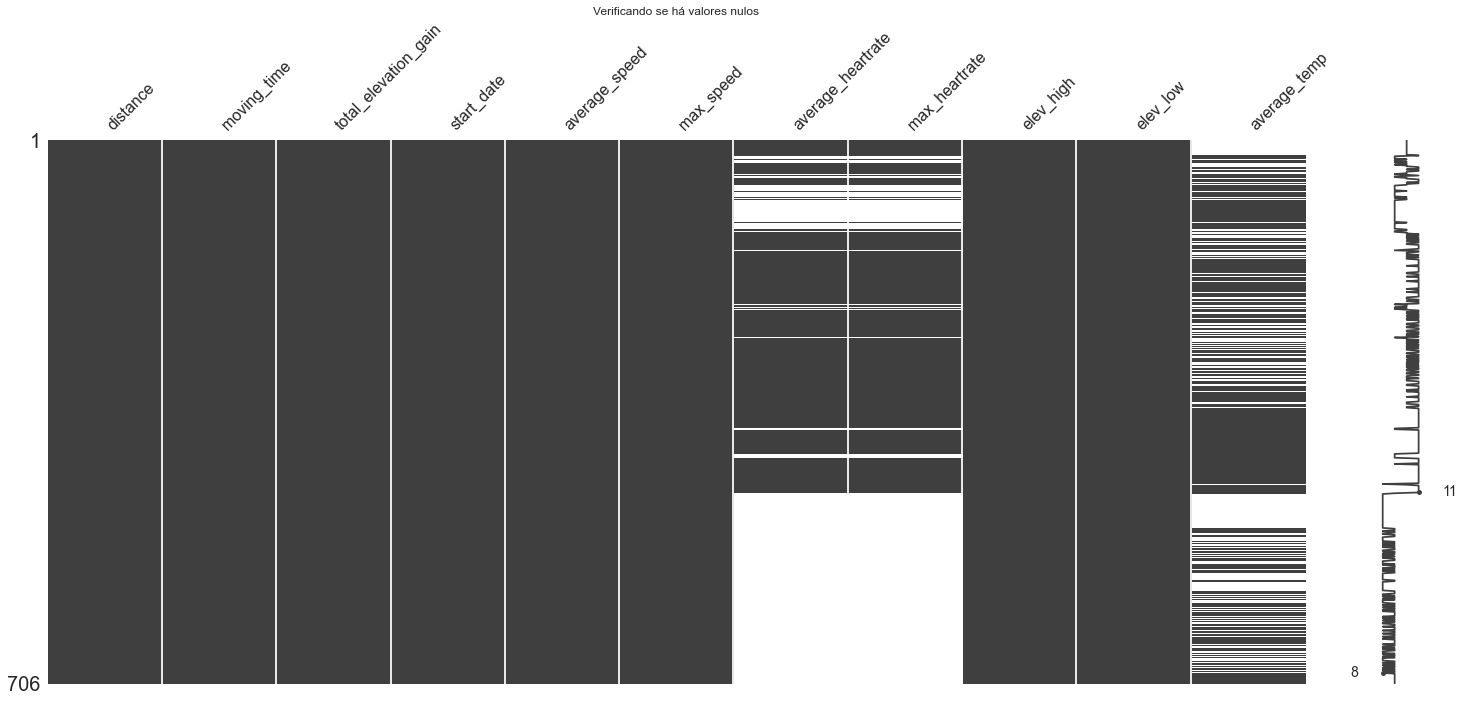

In [58]:
# exibindo visualização matricial da nulidade do dataset
ms.matrix(df_strava)
plt.title('Verificando se há valores nulos')

Tratando os valores nulos do dataset

Text(0.5, 1.0, 'Visulizando se há valores nulos')

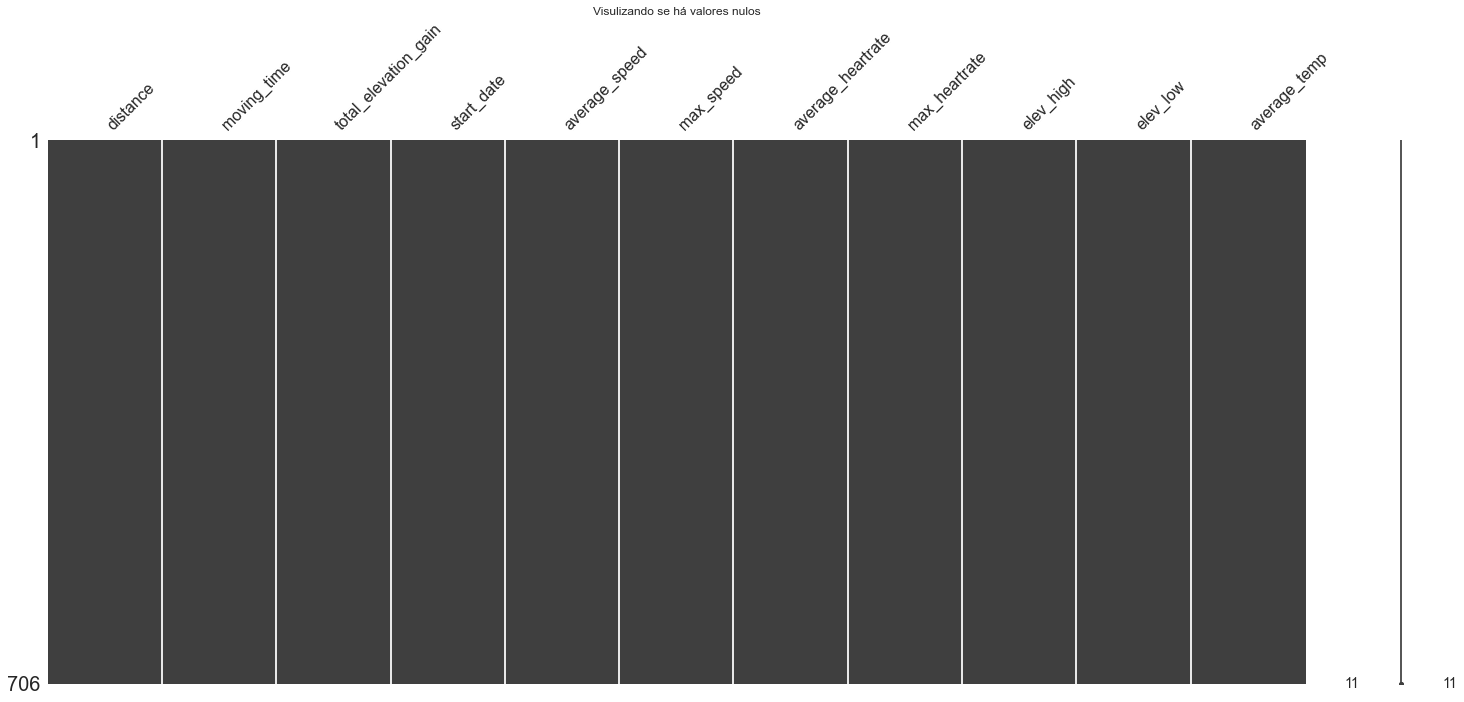

In [59]:
# substituindo os NaN de 'average_heartrate', 'max_heartrate' e 'average_temp' pela mediana da coluna
df_strava['average_heartrate'].fillna(df_strava['average_heartrate'].median(), inplace=True)
df_strava['max_heartrate'].fillna(df_strava['max_heartrate'].median(), inplace=True)
df_strava['average_temp'].fillna(df_strava['average_temp'].median(), inplace=True)

# visualizando se ha valores nulos
ms.matrix(df_strava)
plt.title('Visulizando se há valores nulos')

Inserindo novos atributos como a idade (Age) no periodo da atividade e a frequência cardíaca máxima (FCmax) com base nos existente para melhor análise dos dados.

In [60]:
# convertendo o campo start_date para o tipo data
df_strava['start_date'] = pd.to_datetime(df_strava['start_date'])

# funcao para calcular a idade no periodo da atividade
def calculate_age(birthdate):
    current_date = datetime(1980,11,18)
    age = birthdate.year - current_date.year - ((current_date.month, current_date.day) < (birthdate.month, birthdate.day))
    return age

# criando a nova coluna com o calculo da idade no periodo da atividade
df_strava['Age'] = df_strava['start_date'].apply(calculate_age)

# função para calcular o Frequencia Cardiaca Maxima (FC max)
def calc_fcmax(fcmax):
    fc_max = 220 - fcmax
    return fc_max

# criando a nova coluna com o calculo do FC Max com base na coluna idade
df_strava['FCmax'] = df_strava['Age'].apply(calc_fcmax)

# visualizando o dataframe
df_strava.head()

,distance,moving_time,total_elevation_gain,start_date,average_speed,max_speed,average_heartrate,max_heartrate,elev_high,elev_low,average_temp,Age,FCmax
1,21101.3,6345,546.2,2024-04-07 11:19:35+00:00,3.326,11.460,143.3,205.0,598.3,274.3,26.0,44,176
2,59764.2,11776,779.3,2024-04-06 11:13:37+00:00,5.075,14.545,148.3,177.0,575.1,277.4,26.0,44,176
3,35162.6,6060,616.3,2024-04-03 10:34:20+00:00,5.802,12.472,147.9,181.0,506.1,277.1,26.0,44,176
4,19566.0,3826,367.3,2024-04-02 10:45:59+00:00,5.114,12.807,152.0,191.0,520.1,273.8,26.0,44,176
6,19546.4,4244,373.9,2024-03-19 10:46:01+00:00,4.606,12.215,147.8,182.0,525.2,275.0,26.0,44,176


Neste ponto será criado o alvo (target) com base no atributo 'average_heartrate' (média de batimentos) para as análises seguinte.

In [61]:
df_lrstravatrain = df_strava.loc[:,['distance','moving_time','total_elevation_gain','average_speed','elev_high','max_speed', 'elev_low', 'average_temp']]

df_lrstravatrain['target'] = df_strava['average_heartrate']

df_lrstravatrain.head()

#'max_speed', 'elev_low', , 'average_temp'

,distance,moving_time,total_elevation_gain,average_speed,elev_high,max_speed,elev_low,average_temp,target
1,21101.3,6345,546.2,3.326,598.3,11.460,274.3,26.0,143.3
2,59764.2,11776,779.3,5.075,575.1,14.545,277.4,26.0,148.3
3,35162.6,6060,616.3,5.802,506.1,12.472,277.1,26.0,147.9
4,19566.0,3826,367.3,5.114,520.1,12.807,273.8,26.0,152.0
6,19546.4,4244,373.9,4.606,525.2,12.215,275.0,26.0,147.8


Visualizando a correlação dos atributos.

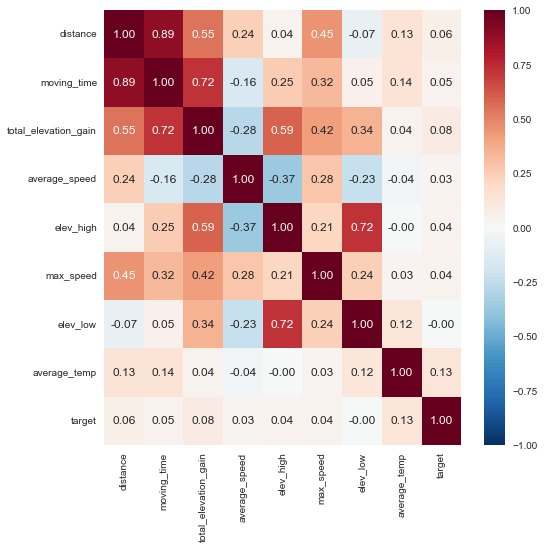

In [62]:
fig, ax = plt.subplots(figsize=(8,8))
ax = heatmap(
    df_lrstravatrain.corr(),
    fmt=".2f",
    annot=True,
    ax=ax,
    cmap="RdBu_r",
    vmin=-1,
    vmax=1,
)

## 1.2 Modelagem
Nesta etapa será realizado uma exploração e preparação dos dados para verificar os modelos que atendam os requisitos de desempenho e precisão.

### 1.2.1 Separação da base
Apartir deste ponto a base é separada em bases de treino e testes

In [63]:
# Separação em bases de treino e teste (holdout)
array = df_lrstravatrain.values

lr_X = array[:,0:8] # atributos
lr_y = array[:,8] # classe (target)

lrX_train, lrX_test, lry_train, lry_test = train_test_split(lr_X, lr_y, test_size=0.3, random_state=42) # faz a divisão da base

# criando so folds
kfold = KFold(n_splits=10, random_state=7, shuffle=True)

### 1.2.2. Avaliando os modelos
Realizando a comparação dos modelos para uma melhor escolha

LR: MSE -31.32 (12.30) - RMSE 5.60
Ridge: MSE -31.32 (12.30) - RMSE 5.60
Lasso: MSE -31.45 (12.50) - RMSE 5.61
KNN: MSE -39.29 (12.95) - RMSE 6.27
CART: MSE -63.07 (18.61) - RMSE 7.94
SVR: MSE -31.65 (12.58) - RMSE 5.63


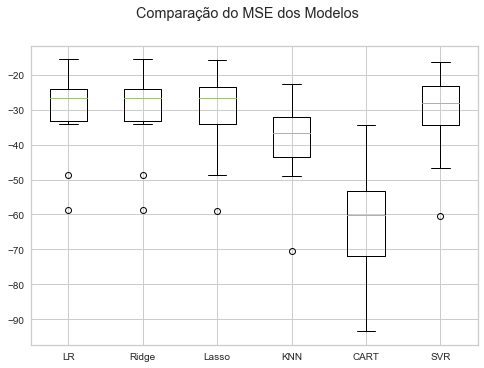

In [64]:
# Modelagem

# Definindo uma seed global para esta célula de código
np.random.seed(10) 

# Listas para armazenar os modelos, os resultados e os nomes dos modelos
models = []
results = []
names = []

# Preparando os modelos e adicionando-os em uma lista
models.append(('LR', LinearRegression()))
models.append(('Ridge', Ridge()))
models.append(('Lasso', Lasso()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))

# Avaliando um modelo por vez
for name, model in models:
  cv_results = cross_val_score(model, lrX_train, lry_train, cv=kfold, scoring='neg_mean_squared_error')
  results.append(cv_results)
  names.append(name)
  msg = "%s: MSE %0.2f (%0.2f) - RMSE %0.2F" % (name, cv_results.mean(), cv_results.std(), np.sqrt(abs(cv_results.mean()))) # média e desvio padrão dos 10 resultados da validação cruzada
  print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure() 
fig.suptitle('Comparação do MSE dos Modelos') 
ax = fig.add_subplot(111) 
plt.boxplot(results) 
ax.set_xticklabels(names) 
plt.show()

No gráfico acima é possível verificar que o modelos indicados são: Regressão Linear (LR), Ridge e Lasso a seguir vamos explora-los.

### 1.2.3 Avalidando modelos com dados originais, padronizados e normalizados

LR-orig: -31.317 (12.301)
KNN-orig: -39.291 (12.947)
CART-orig: -59.889 (17.910)
SVR-orig: -31.651 (12.579)
LR-padr: -31.317 (12.301)
KNN-padr: -35.652 (14.435)
CART-padr: -61.617 (15.861)
SVR-padr: -30.457 (12.427)
LR-norm: -31.317 (12.301)
KNN-norm: -36.812 (14.802)
CART-norm: -58.934 (17.184)
SVR-norm: -30.820 (12.437)


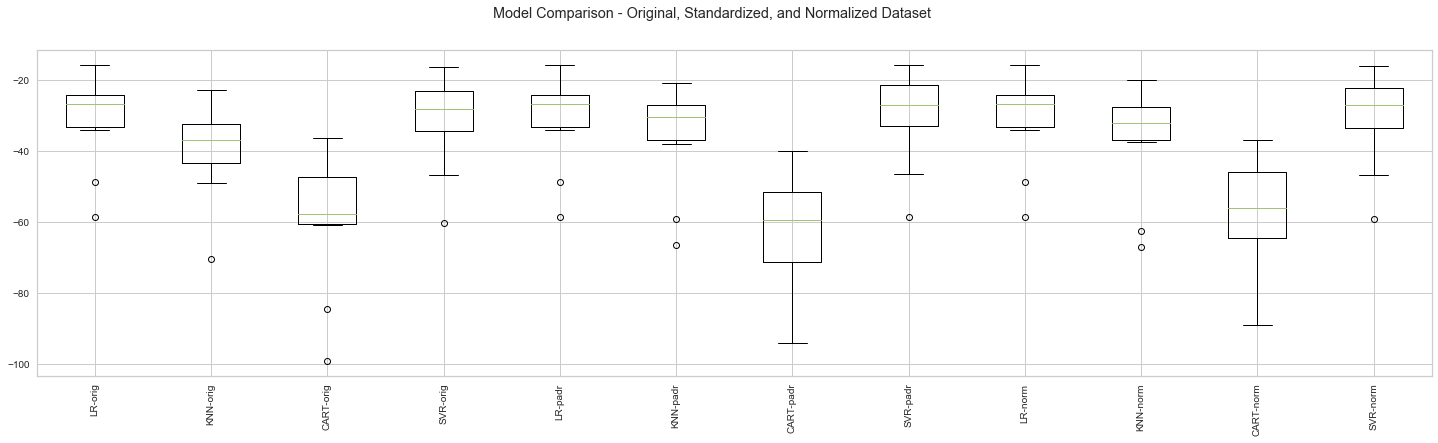

In [65]:
# Defining a global seed for this block
np.random.seed(7)

# Lists to store pipelines and results for all dataset views
pipelines = []
results = []
names = []

# Defining base classifier parameters for the BaggingClassifier
base_classifier = DecisionTreeRegressor()
num_trees = 100
max_features = 4

# Creating the pipeline elements

# Algorithms to be used
reg_log = ('LR', LinearRegression())
knn = ('KNN', KNeighborsRegressor())
cart = ('CART', DecisionTreeRegressor())
svr = ('SVR', SVR())
#random_forest = ('RF', RandomForestRegressor(n_estimators=num_trees, max_features=max_features))

# Transformations to be used
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

# Building the pipelines

# Original dataset
pipelines.append(('LR-orig', Pipeline([reg_log]))) 
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('CART-orig', Pipeline([cart])))
pipelines.append(('SVR-orig', Pipeline([svr])))
#pipelines.append(('RF-orig', Pipeline([random_forest])))

# Standardized dataset
pipelines.append(('LR-padr', Pipeline([standard_scaler, reg_log]))) 
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
pipelines.append(('SVR-padr', Pipeline([standard_scaler, svr])))
#pipelines.append(('RF-padr', Pipeline([standard_scaler, random_forest])))

# Normalized dataset
pipelines.append(('LR-norm', Pipeline([min_max_scaler, reg_log]))) 
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
pipelines.append(('SVR-norm', Pipeline([min_max_scaler, svr])))
#pipelines.append(('RF-norm', Pipeline([min_max_scaler, random_forest])))

# Executing the pipelines
kfold = KFold(n_splits=10, random_state=7, shuffle=True)
scoring = 'neg_mean_squared_error'

for name, model in pipelines:
    cv_results = cross_val_score(model, lrX_train, lry_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std()) # formatting to 3 decimal places
    print(msg)

# Boxplot comparing the models
fig = plt.figure(figsize=(25,6))
fig.suptitle('Model Comparison - Original, Standardized, and Normalized Dataset') 
ax = fig.add_subplot(111) 
plt.boxplot(results) 
ax.set_xticklabels(names, rotation=90)
plt.show()

No gráfico acima observa-se que o modelo SVR padronizado (SVR-padr) tem um melhor resultado 

## 1.3 Análise Modelos
Neste ponto será criado os modelos e analisado os scores e os coeficientes de cada modelo.


Para essa análise os dados serão padronizados seguindo orientação com base no gráfico acima.

In [66]:
# Padronizando os dados
lr_sX = preprocessing.StandardScaler().fit_transform(lr_X)

# separando os dados
sX_train, sX_test, sy_train, sy_test = model_selection.train_test_split(lr_sX, lr_y, test_size=0.3, random_state=42)

#### 1.3.1 Regressão Linear

Criando o modelo de regressão linear com os dados pradronizados

In [67]:
lr = LinearRegression()
lr.fit(sX_train, sy_train)

LinearRegression()

In [68]:
saidat = lr.intercept_\

print(saidat)

151.9196925184841


Visualizando o score do modelo criado

In [69]:
lr.score(sX_test, sy_test)

0.020650255823737362

O score de 0.02 sugere que o modelo de regressão linear não está adequado para descrever a relação entre os recursos e a variável de resposta nos dados fornecidos.

Visualizando o coeficiente

In [70]:
lr.coef_

array([-0.38213237, -0.11029617,  0.92099458,  0.90617077,  0.45184934,
       -0.28384015, -0.4719522 ,  0.90643952])

Gerando gráfico para ver a importância dos atributos na regressão linear.

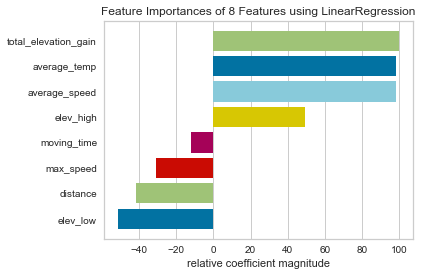

<AxesSubplot:title={'center':'Feature Importances of 8 Features using LinearRegression'}, xlabel='relative coefficient magnitude'>

In [71]:
fig, ax = plt.subplots(figsize=(6,4))
fi_viz = FeatureImportances(lr, labels=df_lrstravatrain.columns)
fi_viz.fit(lr_X, lr_y)
fi_viz.poof()

Observa-se que o atributo total_elevation_gain aumenta o target, enquanto elev_low reduz o valor.

### 1.2.5 SVMs

As SVMs fazem regressão com eficiência na execução e será analisado para uma melhor definição do modelo ideal.

In [72]:
svr = SVR()
svr.fit(sX_train, sy_train)

SVR()

In [73]:
svr.score(sX_test, sy_test)

0.0563027909596201

Aqui observar-se que o score do SVR apresenta um resultado somente de 5,6% de variabilidade dos dados indicando que não esta fazendo boa previsão.

### 1.2.6 K vizinhos mais próximos
Este modelo calcula a média dos alvos para determinar uma predição.

In [74]:
knr = KNeighborsRegressor()
knr.fit(sX_train, sy_train)

KNeighborsRegressor()

In [75]:
knr.score(sX_test, sy_test)

-0.026136627772307852

Pelo modelo apresentar baixa qualidade nos dados e seus atributos o Knr também apresenta baixa resultado para a análise

### 1.2.7. Árvore de decisão
O modelo de árvore de decisão avalia a separação dos atributos em cada nível da árvore.

In [76]:
dtr = DecisionTreeRegressor(random_state=42)
dtr.fit(sX_train, sy_train)

DecisionTreeRegressor(random_state=42)

In [77]:
dtr.score(sX_test, sy_test)

-0.8059096658848393

É possivel observar que o resultado (score) mostra que o modelo não esta bom para análise.

Visualizando a Árvore de Decisão

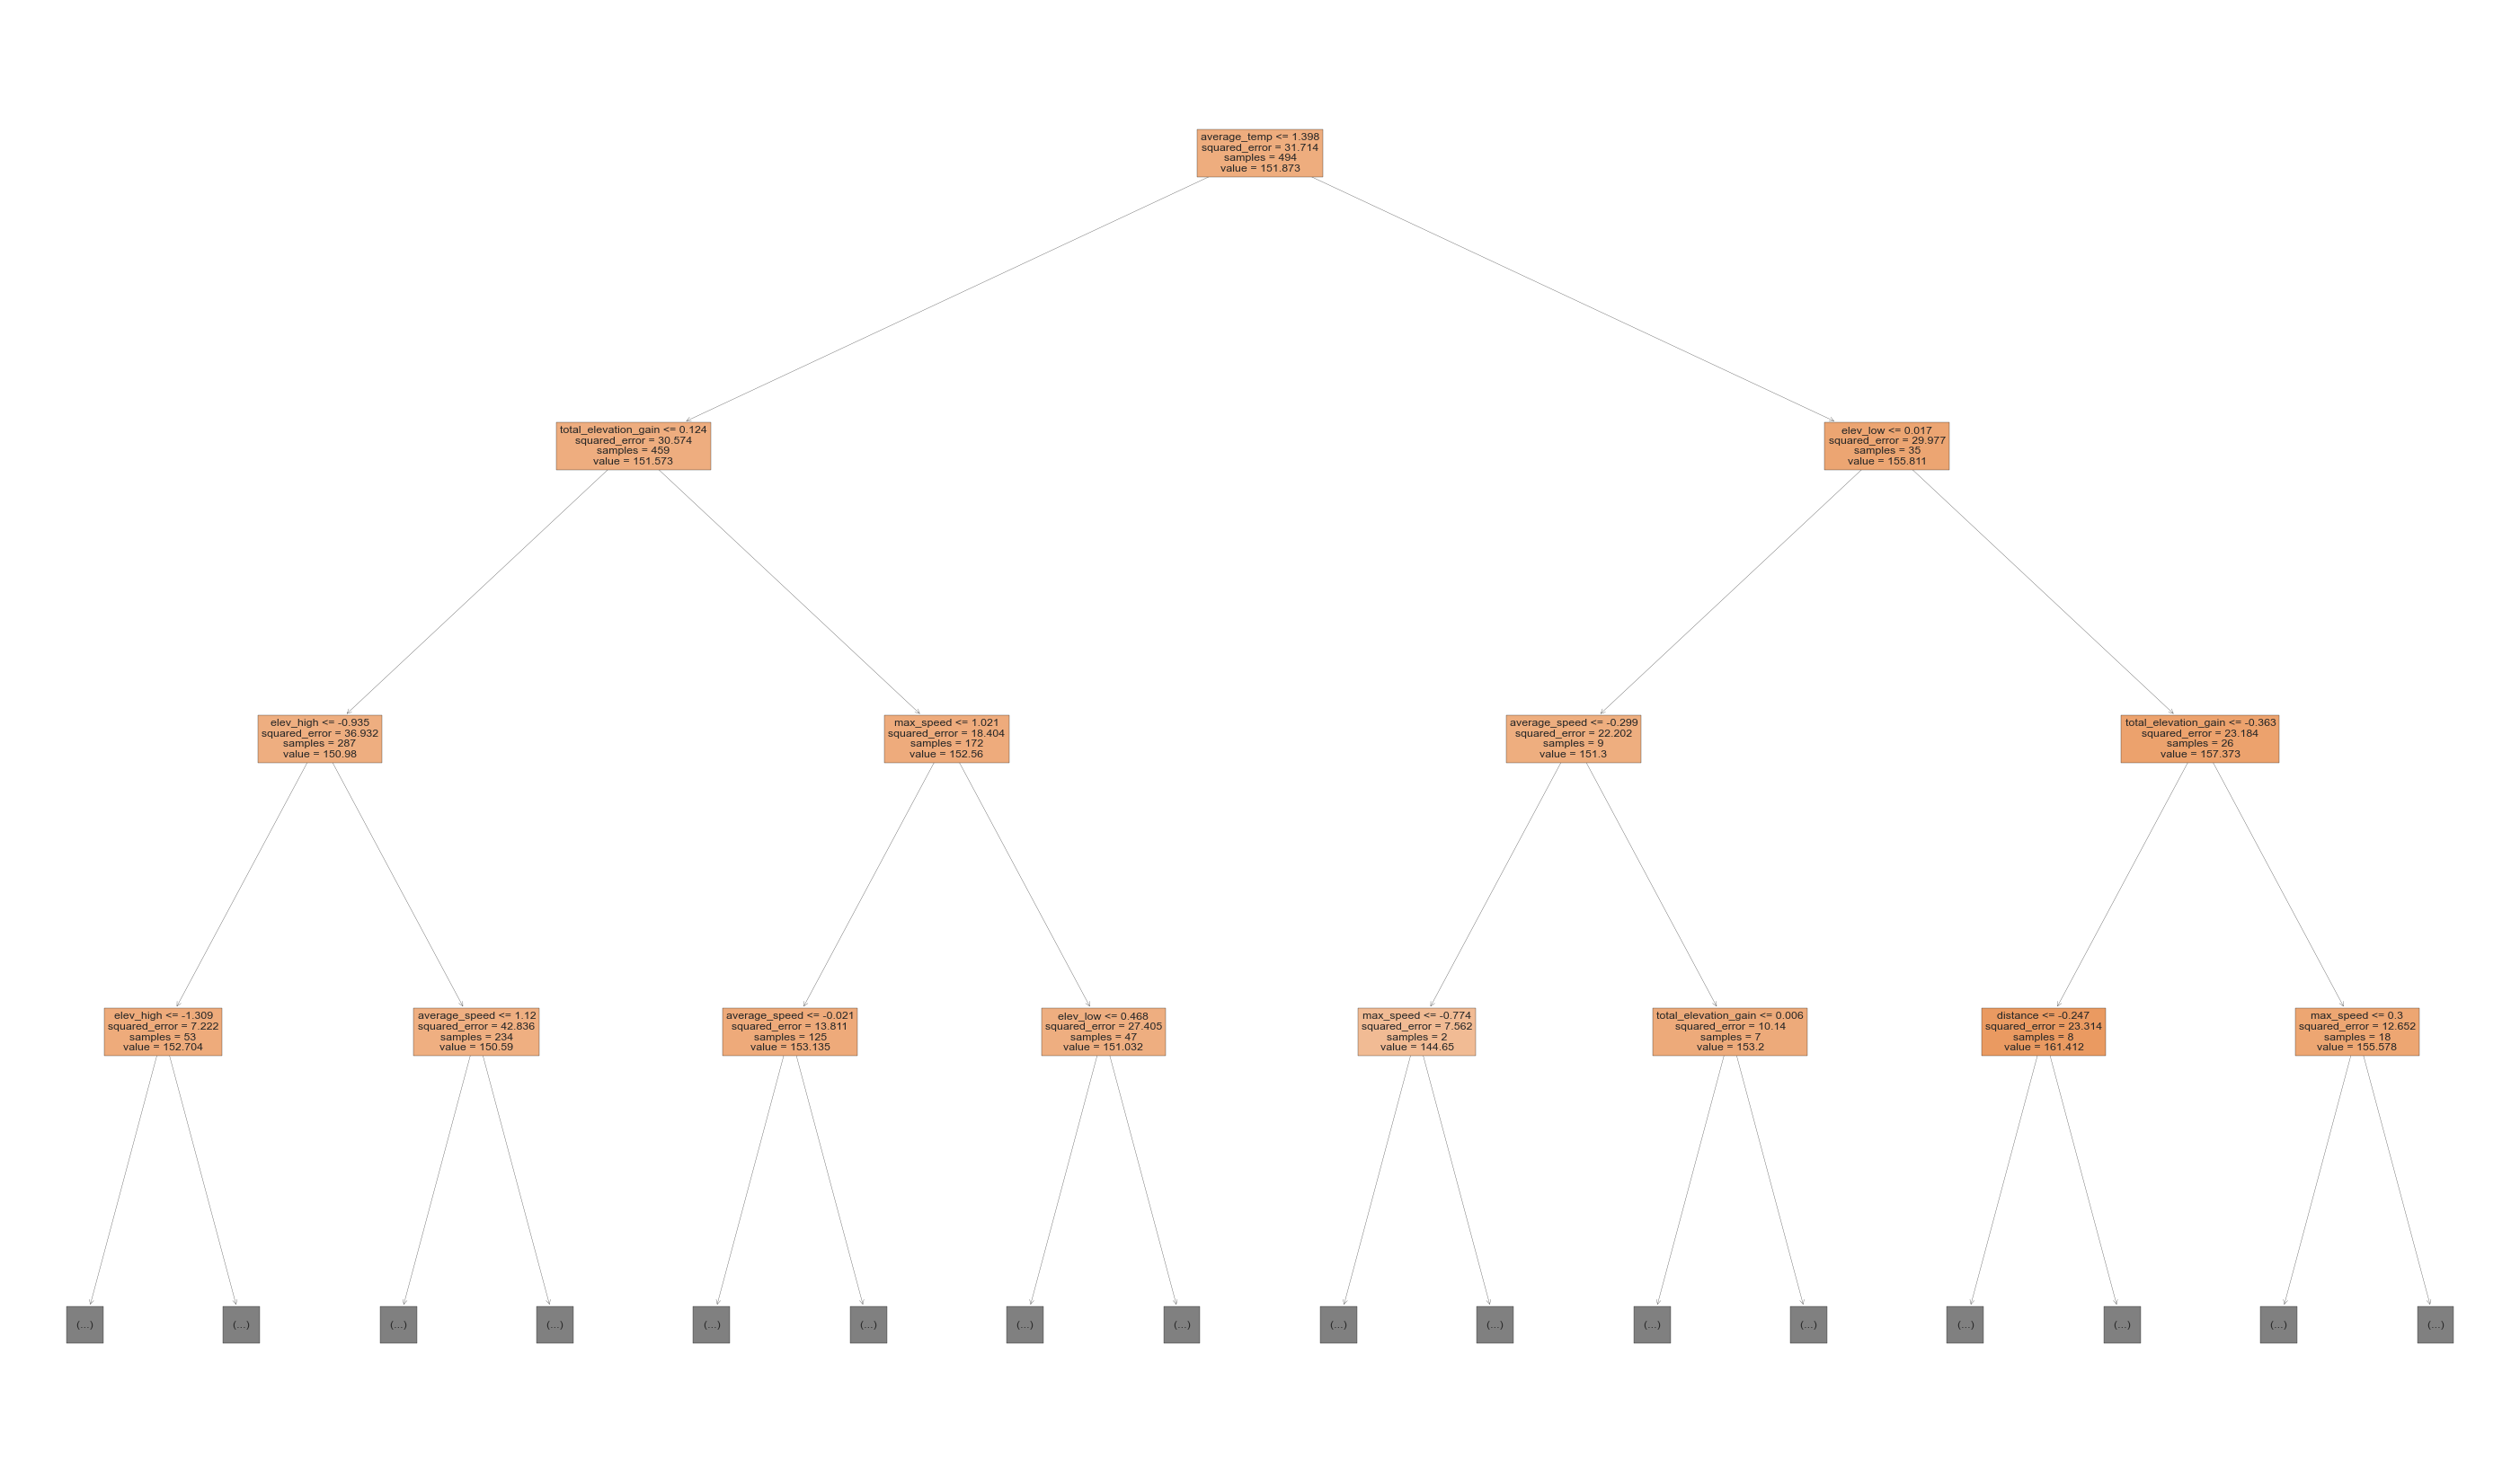

In [78]:
# Plot the CART model
plt.figure(figsize=(50, 30))
plot_tree(dtr, max_depth=3, filled=True, feature_names=df_lrstravatrain.columns, class_names=[str(x) for x in df_lrstravatrain['target'].unique()]) #df_lrstravatrain['target'].astype(str))
plt.show()

Melhor visualização da Árvore de Decisão

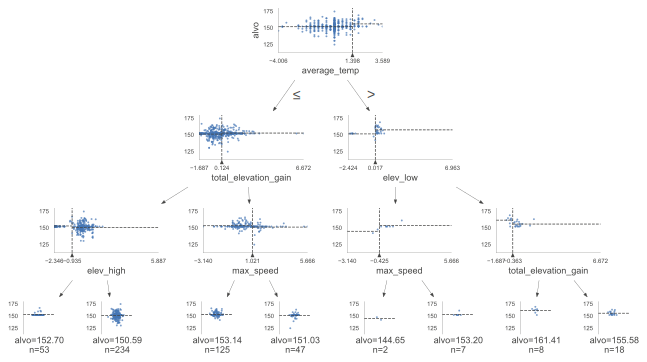

In [79]:
# Arvore de decisao em regressao
dtr3 = DecisionTreeRegressor(max_depth=3)
dtr3.fit(sX_train, sy_train)
viz = dtreeviz.model(
    dtr3,
    sX_train,
    sy_train,
    target_name="alvo",
    feature_names=df_lrstravatrain.columns,
)
viz.view()

Verificando a importância dos atributos na árvore de decisão é possível verificar uma diferença em coparação com o modelo de regressão linear acima.
No gráfico acima é possível observar que há uma tendência para os valores de saída o que não poder ser um bom resultado final.

In [80]:
# importancia dos atributos

for col, val in sorted(
    zip(
        df_lrstravatrain.columns, dtr.feature_importances_
    ),
    key=lambda x: x[1],
    reverse=True,
)[:5]:
    print(f"{col:10}{val:10.3f}")

max_speed      0.228
elev_low       0.168
elev_high      0.134
moving_time     0.111
total_elevation_gain     0.105


### 1.2.8 Floresta Aleatória
A floresta aleatória tem uma tendência melhor de generalização.

In [81]:
# floresta aleatória

rfr = RandomForestRegressor(
    random_state=42, n_estimators=90
)
rfr.fit(sX_train, sy_train)

RandomForestRegressor(n_estimators=90, random_state=42)

In [82]:
rfr.score(sX_test, sy_test)

0.017458550894801195

Assim como os modelos acima o modelo floresta aleatória também não apresenta boa variabilidade nos dados de testes.

In [83]:
# importancia dos atritubos da árvore
for col, val in sorted(
    zip(
        df_lrstravatrain.columns, rfr.feature_importances_
    ),
    key=lambda x: x[1],
    reverse=True,
)[:5]:
    print(f"{col:10}{val:10.3f}")

elev_low       0.175
elev_high      0.164
max_speed      0.126
average_speed     0.124
total_elevation_gain     0.122


### 1.2.9 Regressão XGBosst
A biblioteca XGBoost constroí uma árvore de decisão simples e faz melhorias adicionando árvores subsequentes.

In [84]:
xgr = xgb.XGBRegressor(random_state=42)
xgr.fit(sX_train, sy_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [85]:
xgr.score(sX_test, sy_test)

-0.09332910343000744

Quando você obtém um 
𝑅
2
R 
2
  negativo, isso geralmente sugere que o modelo ajustado está muito mal adaptado aos dados ou que há problemas significativos com o ajuste do modelo. Isso pode ser devido a vários fatores, como:

Falta de relação linear entre os recursos e a variável dependente.
Overfitting do modelo aos dados de treinamento.
Viés significativo nos dados de treinamento.

In [86]:
xgr.predict(lr_X[[0]])

array([160.16608], dtype=float32)

In [87]:
for col, val in sorted(
    zip(
        df_lrstravatrain.columns, xgr.feature_importances_
    ),
    key=lambda x: x[1],
    reverse=True,
)[:5]:
    print(f"{col:10}{val:10.3f}")

average_temp     0.183
elev_low       0.174
elev_high      0.153
max_speed      0.125
average_speed     0.123


Visualizando a importância dos atributos

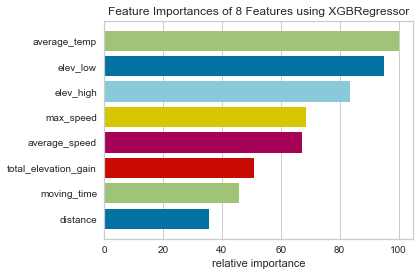

<AxesSubplot:title={'center':'Feature Importances of 8 Features using XGBRegressor'}, xlabel='relative importance'>

In [89]:
fig, ax = plt.subplots(figsize=(6,4))
fi_viz = FeatureImportances(xgr, labels=df_lrstravatrain.columns)
fi_viz.fit(sX_train, sy_train)
fi_viz.poof()

Visualizando a árvore de decisão XGBoost

<AxesSubplot:>

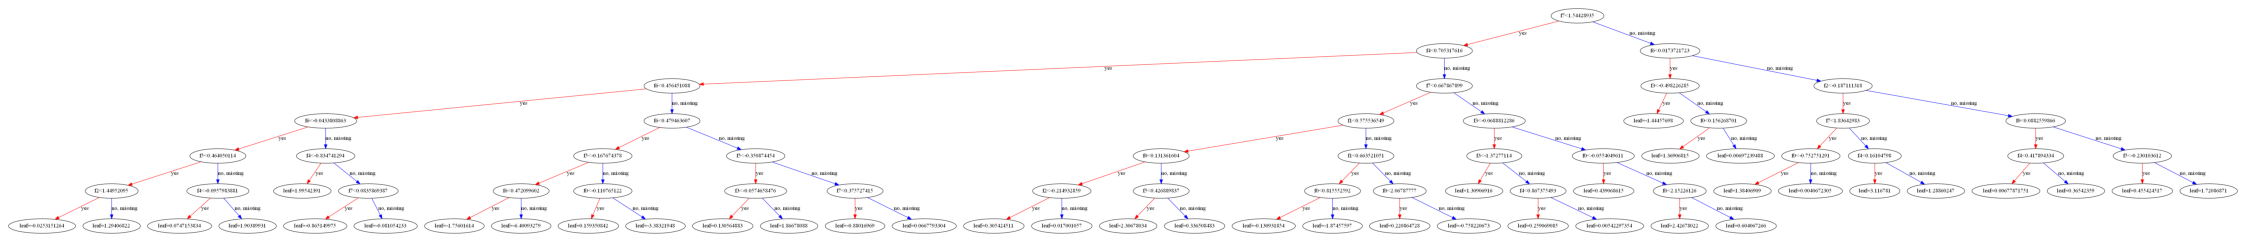

In [90]:
fig, ax = plt.subplots(figsize=(40,20))
xgb.plot_tree(xgr, ax=ax, num_trees=0)

### 1.2.10 Lasso
Lasso (Least Absolute Shrinkage and Selection Operator) faz regressão linear com regularização

In [91]:
# Treinar o modelo Lasso
lasso_model = Lasso(alpha=0.1)  # Escolha do valor de alpha
lasso_model.fit(sX_train, sy_train)

Lasso(alpha=0.1)

In [92]:
lasso_model.score(sX_test, sy_test)

0.025896983646144123

Este modelo só é capaz de responder a 2,5% da variabilidade dos dados.

## 1.4 Métricas e avaliação de regressao
Neste ponto será avalidado o resultado do modelo de regressão de floresta aleatória 

In [134]:
rfr.score(sX_test, sy_test)

0.017458550894801195

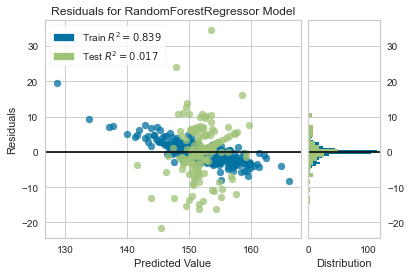

<AxesSubplot:title={'center':'Residuals for RandomForestRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [135]:
# grafico de resíduos
fig, ax = plt.subplots(figsize=(6,4))

rpv = ResidualsPlot(rfr)
rpv.fit(sX_train, sy_train)
rpv.score(sX_test, sy_test)
rpv.poof()


No gráfico acima é possível observar a discrepancia dos valores que pode ter um grande impacto na adequação do modelo.

A biblioteca scipy inclui um gráfico de probabiliddes e o teste de Kolmagorov-Smirnov que verificam se os resíduos tem distribuição normal.

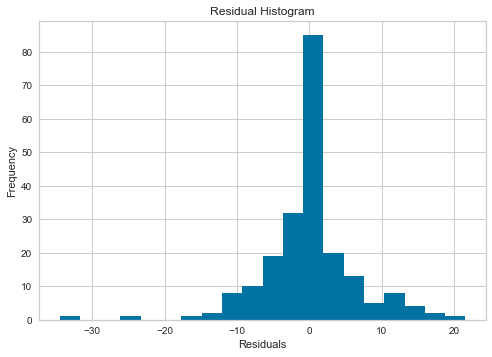

In [95]:
import statsmodels.stats.api as sms
resids = lry_test - rfr.predict(sX_test)
plt.hist(resids, bins=20)
plt.title('Residual Histogram')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

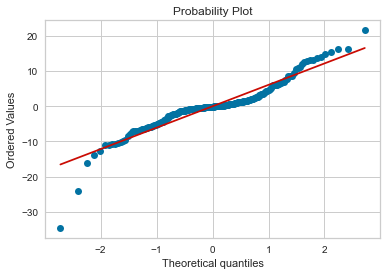

In [96]:

fig, ax = plt.subplots(figsize=(6,4))
_ = stats.probplot(resids, plot=ax)

In [97]:
stats.kstest(resids, cdf="norm")

KstestResult(statistic=0.24115978273691607, pvalue=2.4514535487529243e-11, statistic_location=-1.9955555555553985, statistic_sign=1)

Com os gráficos acima é possível observar que não há um alinhamento na distribuição.
Abaixo visualiza-se o gráfico de erros de predição que mostra que os alvos e os previstos não estão alinhados.

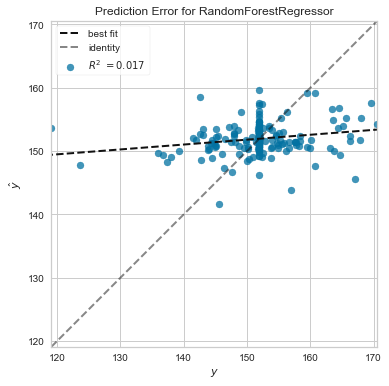

<AxesSubplot:title={'center':'Prediction Error for RandomForestRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [98]:
fig, ax = plt.subplots(figsize=(6,6))
pev = PredictionError(rfr)
pev.fit(sX_train, sy_train)
pev.score(sX_test, sy_test)
pev.poof()

## 1.5 Explicando o modelo

In [99]:
sample_idx = 10
xgr.predict(lr_X[[sample_idx]])

array([160.2361], dtype=float32)

In [100]:
import shap
shap.initjs()
exp = shap.TreeExplainer(xgr)
vals = exp.shap_values(lr_X)

shap.force_plot(
    exp.expected_value,
    vals[sample_idx],
    lr_X[sample_idx]
)

In [101]:
shap.force_plot(
    exp.expected_value, vals, lr_X
)

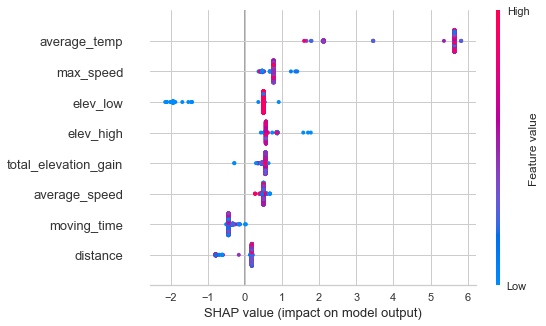

In [102]:
fig, ax = plt.subplots(figsize=(6,4))
shap.summary_plot(vals, lr_X,feature_names=df_lrstravatrain.columns)


Neste gráfico é possível observar o impacto da variável average_temp no modelo e ver que valores maiores empurram o valor do target para cima.

## PCA
Redução da dimensionalidade

In [103]:
pca = PCA(random_state=42)
X_pca = pca.fit_transform(
    StandardScaler().fit_transform(lr_X)
)
pca.explained_variance_ratio_


array([0.38026264, 0.23806528, 0.14175307, 0.12554954, 0.05602071,
       0.03373451, 0.02119249, 0.00342176])

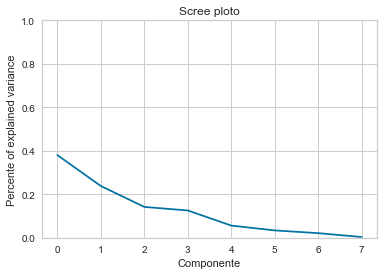

In [104]:
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(pca.explained_variance_ratio_)
ax.set(
    xlabel="Componente",
    ylabel = "Percente of explained variance",
    title="Scree ploto",
    ylim=(0,1),
)
plt.show()

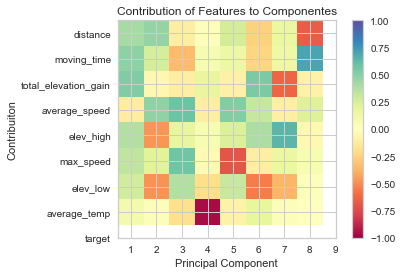

In [105]:
fig, ax = plt.subplots(figsize=(6,4))
plt.imshow(
    pca.components_.T,
    cmap="Spectral",
    vmin=-1,
    vmax=1,
)
plt.yticks(range(len(df_lrstravatrain.columns)), df_lrstravatrain.columns)
plt.xticks(range(9), range(1,10))
plt.xlabel("Principal Component")
plt.ylabel("Contribuiton")
plt.title(
    "Contribution of Features to Componentes"
)
plt.colorbar()

## Otimização Hiperparâmetros
Utilizando o gridsearch para ajuste de hiperparâmetros

In [106]:
# Definir a grade de hiperparâmetros a serem testados
param_grid = {
    'fit_intercept': [True, False],
    'copy_X': [True, False],
    'n_jobs': [True, False],
    'positive': [True, False]
}

# Inicializar a busca em grade
grid_search = GridSearchCV(estimator=lr, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

# Executar a busca em grade nos dados de treinamento
grid_search.fit(sX_train, sy_train)

# Obter o melhor modelo e os melhores parâmetros
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

#print("Melhores Parâmetros:", best_params)

# Avaliar o melhor modelo encontrado
best_model = grid_search.best_estimator_
print("Melhores Hiperparâmetros Encontrados:", grid_search.best_params_)

# Fazer previsões com o melhor modelo
y_pred = best_model.predict(sX_test)

# Calcular o erro quadrático médio (MSE) das previsões
mse = mean_squared_error(sy_test, y_pred)
print("Mean Squared Error (MSE) do Melhor Modelo:", mse)


Fitting 5 folds for each of 16 candidates, totalling 80 fits


Melhores Hiperparâmetros Encontrados: {'copy_X': True, 'fit_intercept': True, 'n_jobs': True, 'positive': False}
Mean Squared Error (MSE) do Melhor Modelo: 40.05683311836013


In [107]:
# Definindo os modelos e seus hiperparâmetros
models = {
    'Linear Regression': {
        'model': LinearRegression(),
        'param_grid': {'fit_intercept': [True, False]}
    },
    'Random Forest': {
        'model': RandomForestRegressor(),
        'param_grid': {'n_estimators': [50, 100, 200]}
    },
    'Support Vector Machine': {
        'model': SVR(),
        'param_grid': {'kernel': ['linear', 'rbf'], 'C': [1, 10, 100]}
    }
}

# Realizando a busca em grade para cada modelo
for model_name, model_params in models.items():
    print(f"Testing {model_name}...")
    grid_search = GridSearchCV(model_params['model'], model_params['param_grid'], cv=5)
    grid_search.fit(sX_train, sy_train)
    print("Best parameters found:")
    print(grid_search.best_params_)
    print("Best score:")
    print(grid_search.best_score_)
    print()

Testing Linear Regression...
Best parameters found:
{'fit_intercept': True}
Best score:
-0.007610453782306248

Testing Random Forest...
Best parameters found:
{'n_estimators': 200}
Best score:
-0.0928719599493952

Testing Support Vector Machine...
Best parameters found:
{'C': 1, 'kernel': 'rbf'}
Best score:
0.024185238836222412



# 2 Avaliação dos Modelos

In [108]:
df_entrada = df.loc[(df['sport_type'] == "Ride") & (df['distance'] >= 10000) & (df['average_heartrate'].isna()),['distance','moving_time','total_elevation_gain','start_date','average_speed','max_speed','average_heartrate','max_heartrate', 'elev_high', 'elev_low','average_temp']]
df_entrada['start_date'] = pd.to_datetime(df_entrada['start_date'])
# funcao para calcular a idade no periodo da atividade
def calculate_age(birthdate_2):
    current_date = datetime(1980,11,18)
    age = birthdate_2.year - current_date.year - ((current_date.month, current_date.day) < (birthdate_2.month, birthdate_2.day))
    return age

# criando a nova coluna com o calculo da idade no periodo da atividade
df_entrada['Age'] = df_entrada['start_date'].apply(calculate_age)

# função para calcular o Frequencia Cardiaca Maxima (FC max)
def calc_fcmax(fcmax):
    fc_max = 220 - fcmax
    return fc_max

# criando a nova coluna com o calculo do FC Max com base na coluna idade
df_entrada['FCmax'] = df_entrada['Age'].apply(calc_fcmax)

df_entrada = df_entrada.loc[:,['distance','moving_time','total_elevation_gain','average_speed','max_speed','elev_high', 'elev_low','average_temp']]

df_entrada = df_entrada.dropna()


#df_entrada = df_entrada.head(20)

df_entrada.head()

,distance,moving_time,total_elevation_gain,average_speed,max_speed,elev_high,elev_low,average_temp
62,18394.9,5827,561.0,3.157,9.772,473.4,205.2,28.0
63,21962.0,5366,563.0,4.093,12.454,470.4,189.4,21.0
64,32064.5,8182,564.0,3.919,11.872,505.0,258.0,24.0
65,17992.0,6091,514.0,2.954,10.422,538.6,211.8,27.0
67,17715.4,6043,502.0,2.932,11.298,483.6,225.8,29.0


### Simulando a aplicação do modelo em dados não vistos

In [109]:
array_entrada = df_entrada.values
X_entrada = array_entrada[:,0:8]

model = xgb.XGBRegressor()
# Preparação do modelo com TODO o dataset
scaler = StandardScaler().fit(lrX_train) # ajuste do scaler com TODO o dataset
rescaledX = scaler.transform(lrX_train) # aplicação da padronização com TODO o dataset
model.fit(rescaledX, lry_train)

#Padronizada dados entrada
rescaladeEntradaX = scaler.transform(X_entrada)
print(rescaladeEntradaX)

[[-9.24840731e-01 -3.07268303e-01  2.02337615e-02 ...  1.69677388e+02
  -1.86132038e-01  7.03658984e-01]
 [-7.39866625e-01 -4.46185086e-01  2.64373167e-02 ...  1.68569870e+02
  -3.29240856e-01 -1.38676436e+00]
 [-2.15995438e-01  4.02382508e-01  2.95390942e-02 ...  1.81343235e+02
   2.92105024e-01 -4.90868639e-01]
 ...
 [ 2.22888196e+00  2.03352469e+00 -1.47792480e+00 ...  1.55628503e+00
  -2.11719533e+00  1.00229089e+00]
 [ 5.93185254e-01  3.17405214e-01 -1.54616391e+00 ... -4.94114888e+00
  -2.15885992e+00 -1.92236733e-01]
 [-4.18927138e-01  1.18103970e+00  1.60834387e+00 ...  2.86852701e+02
   5.69265140e-01 -7.89500544e-01]]


In [110]:
print(X_entrada)

[[ 1.83949e+04  5.82700e+03  5.61000e+02 ...  4.73400e+02  2.05200e+02
   2.80000e+01]
 [ 2.19620e+04  5.36600e+03  5.63000e+02 ...  4.70400e+02  1.89400e+02
   2.10000e+01]
 [ 3.20645e+04  8.18200e+03  5.64000e+02 ...  5.05000e+02  2.58000e+02
   2.40000e+01]
 ...
 [ 7.92123e+04  1.35950e+04  7.80000e+01 ...  1.80000e+01 -8.00000e+00
   2.90000e+01]
 [ 4.76690e+04  7.90000e+03  5.60000e+01 ...  4.00000e-01 -1.26000e+01
   2.50000e+01]
 [ 2.81511e+04  1.07660e+04  1.07300e+03 ...  7.90800e+02  2.88600e+02
   2.30000e+01]]


In [111]:
saidas  = model.predict(rescaladeEntradaX)

print(saidas)

[156.7167  156.32187 156.86343 154.79688 159.45107 159.45338 157.11745
 159.29855 154.05035 154.73393 154.31042 153.34393 155.55139 151.41115
 152.17166 152.43208 159.13329 157.11037 155.21434 160.13449 155.26138
 156.16272 156.06265 153.1723  155.18672 153.3464  152.96606 159.35954
 155.55737 155.075   156.24939 157.64906 159.07216 158.32549 157.30849
 159.5416  158.73811 158.25061 157.16171 157.63998 160.65123 155.9613
 157.91614 158.96347 158.46089 154.3141  157.20383 158.52373 154.49088
 156.30583 159.58875 160.75183 161.29333 152.7147  156.98106 161.24094
 157.75461 151.86348 157.81166 158.72757 158.31404 154.06104 158.37018
 152.67798 157.0948  154.79477 156.50095 156.94931 155.30011 159.9834
 152.67435 157.50081 155.17897 155.23785 155.48068 155.33902 156.3744
 154.68628 153.39844 149.76991 149.01396 151.93983 152.08722 152.97435
 151.06847 152.26279 152.70544 159.34222 154.89304 151.79164 155.12508
 153.33566 155.8128  155.66139 151.9504  152.3607  152.29343 152.50557
 151.9025

In [112]:
df_entrada['saida'] = saidas

df_entrada.head()

,distance,moving_time,total_elevation_gain,average_speed,max_speed,elev_high,elev_low,average_temp,saida
62,18394.9,5827,561.0,3.157,9.772,473.4,205.2,28.0,156.716705
63,21962.0,5366,563.0,4.093,12.454,470.4,189.4,21.0,156.321869
64,32064.5,8182,564.0,3.919,11.872,505.0,258.0,24.0,156.863434
65,17992.0,6091,514.0,2.954,10.422,538.6,211.8,27.0,154.796875
67,17715.4,6043,502.0,2.932,11.298,483.6,225.8,29.0,159.451065


In [113]:
df_entradas = df_strava.loc[df_strava['elev_high'] > 470,['distance','moving_time','total_elevation_gain','average_speed','max_speed','elev_high', 'elev_low','average_temp','average_heartrate']]

df_entradas.head()

,distance,moving_time,total_elevation_gain,average_speed,max_speed,elev_high,elev_low,average_temp,average_heartrate
1,21101.3,6345,546.2,3.326,11.460,598.3,274.3,26.0,143.3
2,59764.2,11776,779.3,5.075,14.545,575.1,277.4,26.0,148.3
3,35162.6,6060,616.3,5.802,12.472,506.1,277.1,26.0,147.9
4,19566.0,3826,367.3,5.114,12.807,520.1,273.8,26.0,152.0
6,19546.4,4244,373.9,4.606,12.215,525.2,275.0,26.0,147.8


Mean Squared Error (MSE): 52.80362066712829
R-squared (R2): -0.237963694864038


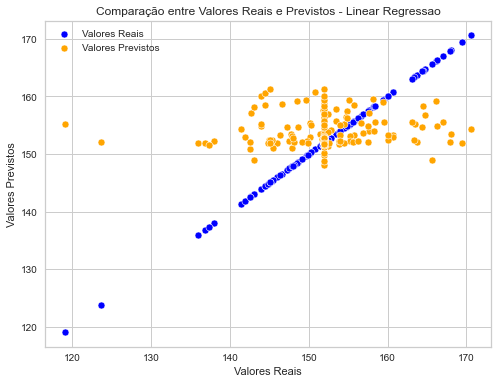

In [114]:
min_length = min(len(lry_test), len(saidas))
y_test = lry_test[:min_length]
y_pred = saidas[:min_length]

# Calcular métricas de desempenho
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)

# Visualizar a relação entre os valores previstos e reais
plt.figure(figsize=(8, 6))
#sns.scatterplot(x=y_test, y=saidas)
sns.scatterplot(x=y_test, y=y_test, color='blue', label='Valores Reais')
sns.scatterplot(x=y_test, y=y_pred, color='orange', label='Valores Previstos')
plt.xlabel("Valores Reais")
plt.ylabel("Valores Previstos")
plt.title("Comparação entre Valores Reais e Previstos - Linear Regressao")
plt.show()

Comparando o teste com dados não visto usando XGboost

In [115]:
xgr_saidas = xgr.predict(rescaladeEntradaX)
print(xgr_saidas)

[155.80777 155.33276 156.51826 156.76968 159.51201 159.25002 156.64351
 159.78561 154.24269 154.52948 154.76479 152.64995 154.41364 146.54698
 152.91705 152.39404 157.07982 155.78654 154.22688 159.66872 155.31677
 155.0975  154.45648 153.20209 154.38222 153.31682 153.78825 159.486
 152.94095 153.86513 152.37889 157.64906 159.9576  154.83238 155.25127
 159.65237 156.68254 157.22134 158.07907 157.63226 158.35268 154.98322
 157.948   159.16595 159.72722 153.25433 157.36446 162.03607 155.10535
 155.28589 159.54062 161.00778 160.4379  152.6848  156.18964 160.508
 162.63531 153.26991 157.2678  157.7741  161.46951 157.74988 157.55705
 154.87473 151.27997 153.17775 154.90108 155.36713 157.31378 159.4862
 151.70425 157.63976 153.26692 155.209   155.08972 155.5664  157.91107
 156.18015 154.18744 147.06273 149.14577 152.11105 152.0618  152.76228
 150.84401 151.46161 151.70291 159.69987 154.88922 156.93904 155.00797
 153.34087 155.64577 155.77055 151.98637 152.50557 152.44633 153.86922
 151.67517 

Mean Squared Error (MSE): 53.41785035301765
R-squared (R2): -0.2523641098702787


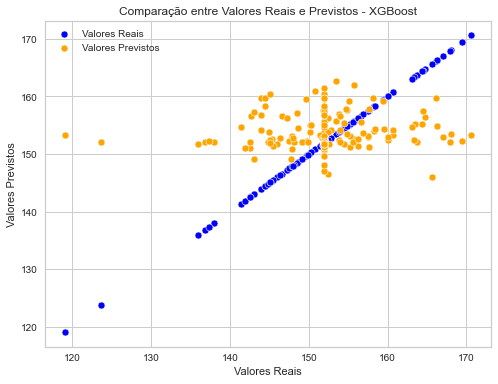

In [116]:
# Calcular métricas de desempenho
mse = mean_squared_error(y_test, xgr_saidas)
r2 = r2_score(y_test, xgr_saidas)

print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)

# Visualizar a relação entre os valores previstos e reais
plt.figure(figsize=(8, 6))
#sns.scatterplot(x=y_test, y=saidas)
sns.scatterplot(x=y_test, y=y_test, color='blue', label='Valores Reais')
sns.scatterplot(x=y_test, y=xgr_saidas, color='orange', label='Valores Previstos')
plt.xlabel("Valores Reais")
plt.ylabel("Valores Previstos")
plt.title("Comparação entre Valores Reais e Previstos - XGBoost")
plt.show()

## Lasso

Mean Squared Error (MSE): 369.2574830583732
R-squared (R2): -7.657121468333571


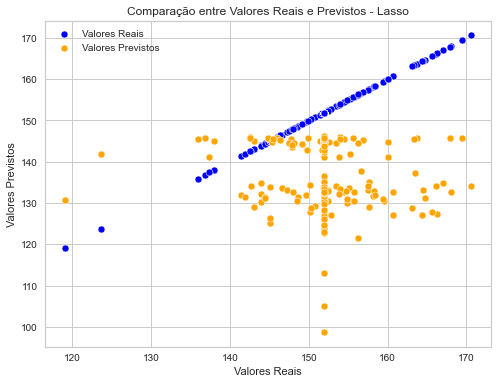

In [117]:
# Treinar o modelo Lasso
lasso_model = Lasso(alpha=0.1)  # Escolha do valor de alpha
lasso_model.fit(lrX_train, lry_train)

# Fazer previsões
lasso_pred = lasso_model.predict(rescaladeEntradaX)


# Calcular métricas de desempenho
mse = mean_squared_error(y_test, lasso_pred)
r2 = r2_score(y_test, lasso_pred)

print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)

# Visualizar a relação entre os valores previstos e reais
plt.figure(figsize=(8, 6))
#sns.scatterplot(x=y_test, y=saidas)
sns.scatterplot(x=y_test, y=y_test, color='blue', label='Valores Reais')
sns.scatterplot(x=y_test, y=lasso_pred, color='orange', label='Valores Previstos')
plt.xlabel("Valores Reais")
plt.ylabel("Valores Previstos")
plt.title("Comparação entre Valores Reais e Previstos - Lasso")
plt.show()

# 3 Conclusão

Conclui-se que o modelo não apresenta boas características para a análise de Regressão, mesmo com testes de remoção e inserção de atributos não foi suficiente para obter um resultado satisfatório para aplicação em um ambiente de produção.

In [ ]:
#novo dataset com dados da base principal sem os valores nulos
df_2 = df.loc[:,['distance','moving_time','total_elevation_gain','average_speed','elev_high','max_speed', 'elev_low', 'average_temp','average_heartrate']]

df_2.rename(columns={'average_heartrate': 'target'}, inplace=True)

df_2 = df_2.dropna()

df_2.shape

array2 = df_2.values
lr2X = array2[:,0:8] # atributos
lr2y = array2[:,8] # classe (target)

# Padronizando os dados
lr2sX = preprocessing.StandardScaler().fit_transform(lr2X)

# separando os dados
vsX_train, vsX_test, vsy_train, vsy_test = model_selection.train_test_split(lr2sX, lr2y, test_size=0.3, random_state=42)

lr2 = LinearRegression()
lr2.fit(vsX_train, vsy_train)

lr2.score(vsX_test, vsy_test)
